In [1]:
from astroquery.jplhorizons import Horizons
from astroquery.jplsbdb import SBDB
from astropy.table import QTable
import astropy.units as u

#import pandas as pd
import numpy as np
import requests
from pprint import pprint
from array import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define access to JPL SBDB

In [37]:
def get_dict(name_list):
    # Return information for each bodies in name_list from JPL Small Body Database in form of dictionair
    # INPUT
    # name_list      list [name1, name2, ..., nameN]
    # OUTPUT
    # dict_bodies    dict with the following structure
    # str(name): "fullname"
    #         "our_id"                is the id inside the new dict, from 0 to N-1 where N is the name_list length
    #         "neo_flag"
    #         "orbit_class"
    #         "pha_flag"
    #         "object_kind"
    #         "moid"
    #         "condition_code"
    #         "rms"
    #         "orbit_comment"
    #         "magn_radius_flag"      is "H" if the next parameter is the magnitude, is "D" if the next parameter is the diameter
    #         "H" or "D"
    #         "spectral_category_flag"     T, S or 0
    #         "spectral_category"
    #         "impacts": str(impact id):   'width'  
    #                                      'energy'
    #                                      'stretch'
    #                                      'ip'
    #                                      'dt'
    #                                      'date'
    #                                      'sigma_lov'
    #                                      'h'
    #                                      'mass'
    #                                      'v_inf'
    #                                      'sigma_imp'
    #                                      'method'
    #                                      'ts'
    #                                      'diam'
    #                                      'dist'
    #                                      'v_imp'
    #                                      'ps'
    
    our_id=0;
    dict_bodies={};

    for name in name_list:
        sbdb = SBDB.query(name, neo_only=True, full_precision=True, phys=True, virtual_impactor=True)
        if sbdb["object"]["kind"]!='cn' or sbdb["object"]["kind"]!='cu' :
            asteroid={"fullname": sbdb["object"]["fullname"],# TODO vogliamo fare un check?
              "our_id":our_id,
              "neo_flag": sbdb["object"]["neo"],
              "orbit_class":sbdb["object"]["orbit_class"]["code"],
              "pha_flag":sbdb["object"]["pha"],
              "object_kind":sbdb["object"]["kind"], #an asteroid numbered au unbered asteroid (cn, cu for comet)
              "moid": sbdb["orbit"]["moid"],
              "condition_code": sbdb["orbit"]["condition_code"], #OCC
              "rms": sbdb["orbit"]["rms"],
              "orbit_comment":sbdb["orbit"]["comment"],
             };
            try:     
                asteroid["magn_radius_flag"]='H';
                asteroid["H"]=sbdb['phys_par']['H'];
            except:
                asteroid["magn_radius_flag"]='D';
                asteroid["D"]=sbdb['phys_par']['diameter'];
            asteroid["impacts"]={}
            flag_bool=1;
            if 'phys_par' in sbdb.keys():
                spect_flag=0;
                if 'spec_T' in sbdb['phys_par'].keys():
                    asteroid["spectral_category_flag"]='T'
                    asteroid["spectral_category"]=sbdb['phys_par']['spec_T']
                    spect_flag=1;
                if 'spec_B' in sbdb['phys_par'].keys():
                    asteroid["spectral_category_flag"]='B'
                    asteroid["spectral_category"]=sbdb['phys_par']['spec_B']
                    spect_flag=1;
                if spect_flag==0:
                    asteroid["spectral_category_flag"]='0'
            else:
                asteroid["spectral_category"]='0'
                
            if 'ip' in sbdb["vi_data"]:
                n_imp=len(sbdb["vi_data"]['ip']);
                for key in sbdb["vi_data"].keys():
                    if flag_bool==1:
                        for i in range(0,n_imp):
                            asteroid["impacts"][str(i)]={};
                        flag_bool=0;
                    for i in range(0,n_imp): 
                        try:
                            asteroid["impacts"][str(i)][key]=sbdb["vi_data"][key][i];
                        except:
                            pprint(name+" could raise error in importing virtual impact data") #this exception is raised if only one impact is present
            dict_bodies[name]=asteroid;
            our_id=our_id+1;
            flag_bool=1;
            del asteroid;
    return dict_bodies
        

# Extract ESA risk list

In [38]:
def extract_esa_name_from_file(file_name):
    f = open(file_name, "r")
    line=f.readline()
    line=f.readline()
    line=f.readline()
    line=f.readline()
    counter=0;
    esa_names=[]
    for line in f:
        word="";
        for c in line:
            if c==' ':
                break;
            else:
                word=word+c;
        esa_names.append(word);  
    return esa_names

In [39]:
esa_risk_names=extract_esa_name_from_file("esa_risk_list.txt");

# Extract SENTRY risk list

In [40]:
def get_sentry_risk_list():
    url = 'https://ssd-api.jpl.nasa.gov/sentry.api'
    r = requests.get(url)
    data = r.json()
    sentry_risk_names=[];
    for i in range(0,len(data['data'])):
        name_=""
        name=data['data'][i]['des'];
        for c in name:
            if c==' ':
                a=0;
            else:
                name_=name_+c;
        sentry_risk_names.append(name_)
    return sentry_risk_names


In [41]:
sentry_risk_names=get_sentry_risk_list()

# Merge risk lists

In [42]:
risk_list=esa_risk_names;
counter=0;
for risk_name in sentry_risk_names:
    if risk_name not in esa_risk_names:
        risk_list.append(risk_name)

# Query SBDB for all risk list elements

In [43]:
dict_risk_list=get_dict(risk_list);

'29075 could raise error in importing virtual impact data'


# DB visualization

# MOID & H

'2010MA113 does not have magnitude info'
'2010MY112 does not have magnitude info'
'2010MZ112 does not have magnitude info'


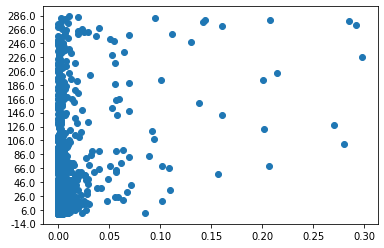

In [44]:
H_=[];
MOID_=[];
for key in dict_risk_list:
    try:
        H_.append(dict_risk_list[key]['H']);
        MOID_.append(dict_risk_list[key]['moid'].scale)
    except:
        pprint(key+' does not have magnitude info')
x = MOID_
y = H_
fig, ax = plt.subplots()
ax.plot(x,y, marker='o', linewidth=0)
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(-14, 306, 20))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.show()

# List only asteroids with known spectral type

In [45]:
spectral_known=[];
for key in dict_risk_list.keys():
    if (dict_risk_list[key]['spectral_category_flag']=="B") or (dict_risk_list[key]['spectral_category_flag']=="T"):
        spectral_known.append('key');
        pprint(key)

'101955'


# Requirements filter

# MOID<=0.05au, H<=22 (if H is not available diameter>=400m)

In [46]:
MOID_H_selected=[];
for key in dict_risk_list.keys():
    if float(dict_risk_list[key]['moid'].scale)<=0.05: #MOID<=0.05 AU
        if (dict_risk_list[key]["magn_radius_flag"]=='H' and float(dict_risk_list[key]["H"])<=22) or (dict_risk_list[key]["magn_radius_flag"]=='D' and float(dict_risk_list[key]["D"])>=400):
            MOID_H_selected.append(key)

# At least one impact 2026<year<22048 with a Palermo Scale>=-5

In [47]:
date_selected=[];
PS_date_selected=[]
for key in dict_risk_list.keys():
    if '0' in dict_risk_list[key]['impacts'].keys():
        max_P=-100;
        date_flag=0;
        for imp_id in dict_risk_list[key]['impacts'].keys():
            word='';
            for c in dict_risk_list[key]['impacts'][imp_id]['date']:
                #pprint(c)
                if c=='-':
                    break;
                else:
                    word=word+c;
            if int(word)<2048 and int(word)>2026:
                date_flag=1;
                if float(dict_risk_list[key]['impacts'][imp_id]['ps'])>max_P:
                    max_P=float(dict_risk_list[key]['impacts'][imp_id]['ps']);
        if date_flag==1:
            date_selected.append(key)
            if max_P>=-5:
                PS_date_selected.append(key)

# Intersect filtered lists

In [48]:
refined_selected=list(set(PS_date_selected) & set(MOID_H_selected))

# REPORT RESULTS:

In [49]:
pprint('on date and PS:')
pprint(PS_date_selected)
pprint('on MOID and H:')
pprint(MOID_H_selected)
pprint('refined search:')
pprint(refined_selected)

'on date and PS:'
['2008JL3',
 '2011DU9',
 '2012QD8',
 '2005QK76',
 '2007KE4',
 '2014MR26',
 '2012MF7',
 '2008CC71',
 '2007FT3',
 '2020XE',
 '2006DM63',
 '2018DQ',
 '1995CS',
 '2012VE77',
 '2016EO28',
 '2020YN',
 '2016WN55',
 '2016NL56']
'on MOID and H:'
['1979XB',
 '2001VB',
 '2007FT3',
 '2006CM10',
 '2002GM5',
 '2017QC36',
 '2020FA5',
 '2007PR25',
 '2011BT59',
 '2017AB21',
 '2021ED5',
 '2004GE2',
 '2016NL56',
 '2001CA21',
 '2014MV67',
 '29075',
 '101955']
'refined search:'
['2007FT3', '2016NL56']


In [50]:
for selected in refined_selected:
    pprint(dict_risk_list[selected])

{'H': '20.0',
 'condition_code': '9',
 'fullname': '(2007 FT3)',
 'impacts': {'0': {'date': '2024-10-02.85',
                   'diam': <Quantity 0.34 km>,
                   'dist': 52.116,
                   'dt': <Quantity 3.52 yr>,
                   'energy': 2724.0,
                   'h': <Quantity 19.97 mag>,
                   'ip': 7.47e-08,
                   'mass': <Quantity 5.507e+10 kg>,
                   'method': 'LOV',
                   'ps': -3.46,
                   'sigma_imp': 1.079,
                   'sigma_lov': -0.82761,
                   'stretch': 54765.0,
                   'ts': 0.0,
                   'v_imp': <Quantity 20.38 km / s>,
                   'v_inf': <Quantity 17.07 km / s>,
                   'width': 47.357},
             '1': {'date': '2025-10-03.64',
                   'diam': <Quantity 0.34 km>,
                   'dist': 134.186,
                   'dt': <Quantity 4.52 yr>,
                   'energy': 2637.0,
                   'h': 

             '146': {'date': '2108-10-04.43',
                     'diam': <Quantity 0.34 km>,
                     'dist': 95.068,
                     'dt': <Quantity 87.52 yr>,
                     'energy': 2672.0,
                     'h': <Quantity 19.98 mag>,
                     'ip': 7.115e-10,
                     'mass': <Quantity 5.422e+10 kg>,
                     'method': 'LOV',
                     'ps': -6.83,
                     'sigma_imp': 2.018,
                     'sigma_lov': -0.5371,
                     'stretch': 1632100.0,
                     'ts': 0.0,
                     'v_imp': <Quantity 20.35 km / s>,
                     'v_inf': <Quantity 17.02 km / s>,
                     'width': 46.623},
             '147': {'date': '2109-10-04.23',
                     'diam': <Quantity 0.34 km>,
                     'dist': 61.345,
                     'dt': <Quantity 88.52 yr>,
                     'energy': 2744.0,
                     'h': <Quantity 19.97 

                   'sigma_lov': -0.5278,
                   'stretch': 3660700.0,
                   'ts': 0.0,
                   'v_imp': <Quantity 20.35 km / s>,
                   'v_inf': <Quantity 17.02 km / s>,
                   'width': 46.053},
             '50': {'date': '2077-10-03.23',
                    'diam': <Quantity 0.34 km>,
                    'dist': 41.813,
                    'dt': <Quantity 56.52 yr>,
                    'energy': 2725.0,
                    'h': <Quantity 19.97 mag>,
                    'ip': 1.061e-09,
                    'mass': <Quantity 5.508e+10 kg>,
                    'method': 'LOV',
                    'ps': -6.46,
                    'sigma_imp': 0.869,
                    'sigma_lov': -0.83007,
                    'stretch': 4782700.0,
                    'ts': 0.0,
                    'v_imp': <Quantity 20.39 km / s>,
                    'v_inf': <Quantity 17.07 km / s>,
                    'width': 46.961},
             '51': {'d

{'H': '19.597',
 'condition_code': '9',
 'fullname': '(2016 NL56)',
 'impacts': {'0': {'date': '2023-02-20.28',
                   'diam': <Quantity 0.19 km>,
                   'dist': 165.881,
                   'dt': <Quantity 1.91 yr>,
                   'energy': 355.6,
                   'h': <Quantity 21.26 mag>,
                   'ip': 2.7e-09,
                   'mass': <Quantity 9.293e+09 kg>,
                   'method': 'LOV',
                   'ps': -5.31,
                   'sigma_imp': 2.224,
                   'sigma_lov': -1.91524,
                   'stretch': 35897.0,
                   'ts': 0.0,
                   'v_imp': <Quantity 17.93 km / s>,
                   'v_inf': <Quantity 14.04 km / s>,
                   'width': 74.135},
             '1': {'date': '2024-09-05.84',
                   'diam': <Quantity 0.28 km>,
                   'dist': 182.724,
                   'dt': <Quantity 3.45 yr>,
                   'energy': 1315.0,
                   'h'

                     'sigma_imp': 0.916,
                     'sigma_lov': -0.75177,
                     'stretch': 6847100.0,
                     'ts': 0.0,
                     'v_imp': <Quantity 18.94 km / s>,
                     'v_inf': <Quantity 15.31 km / s>,
                     'width': 180.37},
             '126': {'date': '2085-08-29.33',
                     'diam': <Quantity 0.19 km>,
                     'dist': 29.246,
                     'dt': <Quantity 64.43 yr>,
                     'energy': 353.9,
                     'h': <Quantity 21.26 mag>,
                     'ip': 1.347e-10,
                     'mass': <Quantity 9.266e+09 kg>,
                     'method': 'LOV',
                     'ps': -8.12,
                     'sigma_imp': 2.126,
                     'sigma_lov': -1.91904,
                     'stretch': 4332700.0,
                     'ts': 0.0,
                     'v_imp': <Quantity 17.91 km / s>,
                     'v_inf': <Quantity 14.02 

                     'dt': <Quantity 76.45 yr>,
                     'energy': 1350.0,
                     'h': <Quantity 20.38 mag>,
                     'ip': 1.624e-10,
                     'mass': <Quantity 3.137e+10 kg>,
                     'method': 'LOV',
                     'ps': -7.65,
                     'sigma_imp': 0.769,
                     'sigma_lov': -0.7221,
                     'stretch': 9391900.0,
                     'ts': 0.0,
                     'v_imp': <Quantity 19.01 km / s>,
                     'v_inf': <Quantity 15.4 km / s>,
                     'width': 189.95},
             '186': {'date': '2097-09-06.94',
                     'diam': <Quantity 0.29 km>,
                     'dist': 167.384,
                     'dt': <Quantity 76.45 yr>,
                     'energy': 1429.0,
                     'h': <Quantity 20.34 mag>,
                     'ip': 1.328e-09,
                     'mass': <Quantity 3.297e+10 kg>,
                     'method': 'LO

                     'sigma_lov': -2.28519,
                     'stretch': 151730.0,
                     'ts': 0.0,
                     'v_imp': <Quantity 17.87 km / s>,
                     'v_inf': <Quantity 13.97 km / s>,
                     'width': 91.773},
             '239': {'date': '2114-03-11.17',
                     'diam': <Quantity 0.3 km>,
                     'dist': 61.766,
                     'dt': <Quantity 92.96 yr>,
                     'energy': 1606.0,
                     'h': <Quantity 20.27 mag>,
                     'ip': 4.547e-10,
                     'mass': <Quantity 3.631e+10 kg>,
                     'method': 'LOV',
                     'ps': -7.22,
                     'sigma_imp': 0.192,
                     'sigma_lov': -0.60886,
                     'stretch': 2859600.0,
                     'ts': 0.0,
                     'v_imp': <Quantity 19.27 km / s>,
                     'v_inf': <Quantity 15.72 km / s>,
                     'width': 316

                   'dt': <Quantity 12.43 yr>,
                   'energy': 417.2,
                   'h': <Quantity 21.15 mag>,
                   'ip': 8.353e-09,
                   'mass': <Quantity 1.085e+10 kg>,
                   'method': 'LOV',
                   'ps': -5.57,
                   'sigma_imp': 1.601,
                   'sigma_lov': -1.73485,
                   'stretch': 98083.0,
                   'ts': 0.0,
                   'v_imp': <Quantity 17.97 km / s>,
                   'v_inf': <Quantity 14.1 km / s>,
                   'width': 39.099},
             '60': {'date': '2065-03-19.19',
                    'diam': <Quantity 0.35 km>,
                    'dist': 26.655,
                    'dt': <Quantity 43.98 yr>,
                    'energy': 2921.0,
                    'h': <Quantity 19.91 mag>,
                    'ip': 2.023e-10,
                    'mass': <Quantity 5.958e+10 kg>,
                    'method': 'LOV',
                    'ps': -7.04,
   